In [1]:
import pandas as pd
import sqlite3
from IPython.display import display

from src.paths import SQL_DB_DIR
from src.paths import TAXI_ZONES_DIR

In [2]:
df_location_info = pd.read_parquet(TAXI_ZONES_DIR/'taxi_zones_df.parquet')
df_location_info

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,Latitude,Longitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,40.691830,-74.174002
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,40.616746,-73.831300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,40.864474,-73.847422
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.723752,-73.976968
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,40.552659,-74.188485
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,40.897932,-73.852215
259,260,0.133514,0.000422,Woodside,260,Queens,40.744234,-73.906307
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,40.709139,-74.013023
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,40.775932,-73.946510


In [3]:
con = sqlite3.connect(SQL_DB_DIR/'nyc_taxi_data.db')

In [4]:
df_columns = pd.read_sql_query('PRAGMA table_info(yellow_taxi_data)', con)
df_columns

,cid,name,type,notnull,dflt_value,pk
0,0,VendorID,BIGINT,0,None,0
1,1,tpep_pickup_datetime,DATETIME,0,None,0
2,2,tpep_dropoff_datetime,DATETIME,0,None,0
3,3,passenger_count,FLOAT,0,None,0
4,4,trip_distance,FLOAT,0,None,0
5,5,RatecodeID,FLOAT,0,None,0
6,6,store_and_fwd_flag,TEXT,0,None,0
7,7,PULocationID,BIGINT,0,None,0
8,8,DOLocationID,BIGINT,0,None,0
9,9,payment_type,BIGINT,0,None,0


In [5]:
df_shape = pd.read_sql_query('SELECT COUNT(*) FROM yellow_taxi_data', con)
df_shape

,COUNT(*)
0,38310122


In [6]:
df_pickup_location = pd.read_sql_query('SELECT PULocationID as LocationID, COUNT(*) as PickupCount \
                                       FROM yellow_taxi_data \
                                       GROUP BY PULocationID',con)
df_pickup_location

,LocationID,PickupCount
0,1,5105
1,2,35
2,3,836
3,4,47518
4,5,387
...,...,...
258,261,198639
259,262,511237
260,263,726575
261,264,356727


In [7]:
df_dropoff_location = pd.read_sql_query('SELECT DOLocationID as LocationID, COUNT(*) as DropoffCount \
                                       FROM yellow_taxi_data \
                                       GROUP BY DOLocationID',con)
df_dropoff_location

,LocationID,DropoffCount
0,1,117694
1,2,78
2,3,3140
3,4,146689
4,5,538
...,...,...
257,261,184307
258,262,581101
259,263,782181
260,264,386725


In [8]:
con.close()

In [9]:
# df_location_info is a DataFrame containing LocationID, zone, and borough

# Initial Preparation: Create a complete range of LocationIDs to ensure all locations are included.
# Calculate the maximum LocationID across all datasets
max_location_id = max(df_location_info.index.max(), 
                      df_pickup_location['LocationID'].max(), 
                      df_dropoff_location['LocationID'].max())
max_location_id


265

In [10]:
# Create a complete DataFrame of LocationIDs to ensure all locations are represented
all_location_ids = pd.DataFrame(range(1, max_location_id + 1), columns=["LocationID"])

# Combine pickup and dropoff counts, setting missing values to 0
combined_counts = pd.concat([
    df_pickup_location.rename(columns={'PickupCount': 'count'}).assign(activity='pickup'),
    df_dropoff_location.rename(columns={'DropoffCount': 'count'}).assign(activity='dropoff')
]).pivot_table(index='LocationID', columns='activity', values='count', aggfunc='sum', fill_value=0).reset_index()

# Merge to include all LocationIDs and fill missing values
df_zones = all_location_ids.merge(combined_counts, on='LocationID', how='left').fillna(0)
df_zones['TOTALcount'] = df_zones['pickup'] + df_zones['dropoff']

# Merge with location info, considering LocationID as the index in df_location_info
df_zones = df_zones.merge(df_location_info, left_on='LocationID', right_index=True, how='left')
df_zones


,LocationID,LocationID_x,dropoff,pickup,TOTALcount,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID_y,borough,Latitude,Longitude
0,1,1,117694.0,5105.0,122799.0,2.0,0.433470,0.004866,Jamaica Bay,2.0,Queens,40.616746,-73.831300
1,2,2,78.0,35.0,113.0,3.0,0.084341,0.000314,Allerton/Pelham Gardens,3.0,Bronx,40.864474,-73.847422
2,3,3,3140.0,836.0,3976.0,4.0,0.043567,0.000112,Alphabet City,4.0,Manhattan,40.723752,-73.976968
3,4,4,146689.0,47518.0,194207.0,5.0,0.092146,0.000498,Arden Heights,5.0,Staten Island,40.552659,-74.188485
4,5,5,538.0,387.0,925.0,6.0,0.150491,0.000606,Arrochar/Fort Wadsworth,6.0,Staten Island,40.600324,-74.071770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,261,261,184307.0,198639.0,382946.0,262.0,0.049064,0.000122,Yorkville East,262.0,Manhattan,40.775932,-73.946510
261,262,262,581101.0,511237.0,1092338.0,263.0,0.037017,0.000066,Yorkville West,263.0,Manhattan,40.778766,-73.951010
262,263,263,782181.0,726575.0,1508756.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,264,264,386725.0,356727.0,743452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_zones.drop(columns=['LocationID_x', 'LocationID_y'], inplace=True)

In [12]:
# Calculate top 5 locations for pickups and dropoffs, then reset the index
PUtop5 = df_zones.nlargest(5, 'pickup').reset_index(drop=True)
DOtop5 = df_zones.nlargest(5, 'dropoff').reset_index(drop=True)

# Optional: Convert counts to dictionaries
PUcount_dict = dict(zip(df_zones['LocationID'], df_zones['pickup']))
DOcount_dict = dict(zip(df_zones['LocationID'], df_zones['dropoff']))

In [13]:
PUtop5

,LocationID,dropoff,pickup,TOTALcount,OBJECTID,Shape_Leng,Shape_Area,zone,borough,Latitude,Longitude
0,132,479642.0,1992276.0,2471918.0,133.0,0.065135,0.000157,Kensington,Brooklyn,40.640590,-73.976199
1,237,1605268.0,1791793.0,3397061.0,238.0,0.060109,0.000185,Upper West Side North,Manhattan,40.791705,-73.973049
2,161,1484677.0,1766037.0,3250714.0,162.0,0.035270,0.000048,Midtown East,Manhattan,40.756688,-73.972356
3,236,1677190.0,1596582.0,3273772.0,237.0,0.042213,0.000096,Upper East Side South,Manhattan,40.768615,-73.965635
4,162,1083162.0,1353751.0,2436913.0,163.0,0.034177,0.000041,Midtown North,Manhattan,40.764421,-73.977569


In [14]:
DOtop5

,LocationID,dropoff,pickup,TOTALcount,OBJECTID,Shape_Leng,Shape_Area,zone,borough,Latitude,Longitude
0,236,1677190.0,1596582.0,3273772.0,237.0,0.042213,0.000096,Upper East Side South,Manhattan,40.768615,-73.965635
1,237,1605268.0,1791793.0,3397061.0,238.0,0.060109,0.000185,Upper West Side North,Manhattan,40.791705,-73.973049
2,161,1484677.0,1766037.0,3250714.0,162.0,0.035270,0.000048,Midtown East,Manhattan,40.756688,-73.972356
3,230,1178618.0,1270677.0,2449295.0,231.0,0.063420,0.000167,TriBeCa/Civic Center,Manhattan,40.717773,-74.007880
4,170,1128236.0,1131671.0,2259907.0,171.0,0.107354,0.000520,Murray Hill-Queens,Queens,40.768352,-73.809545


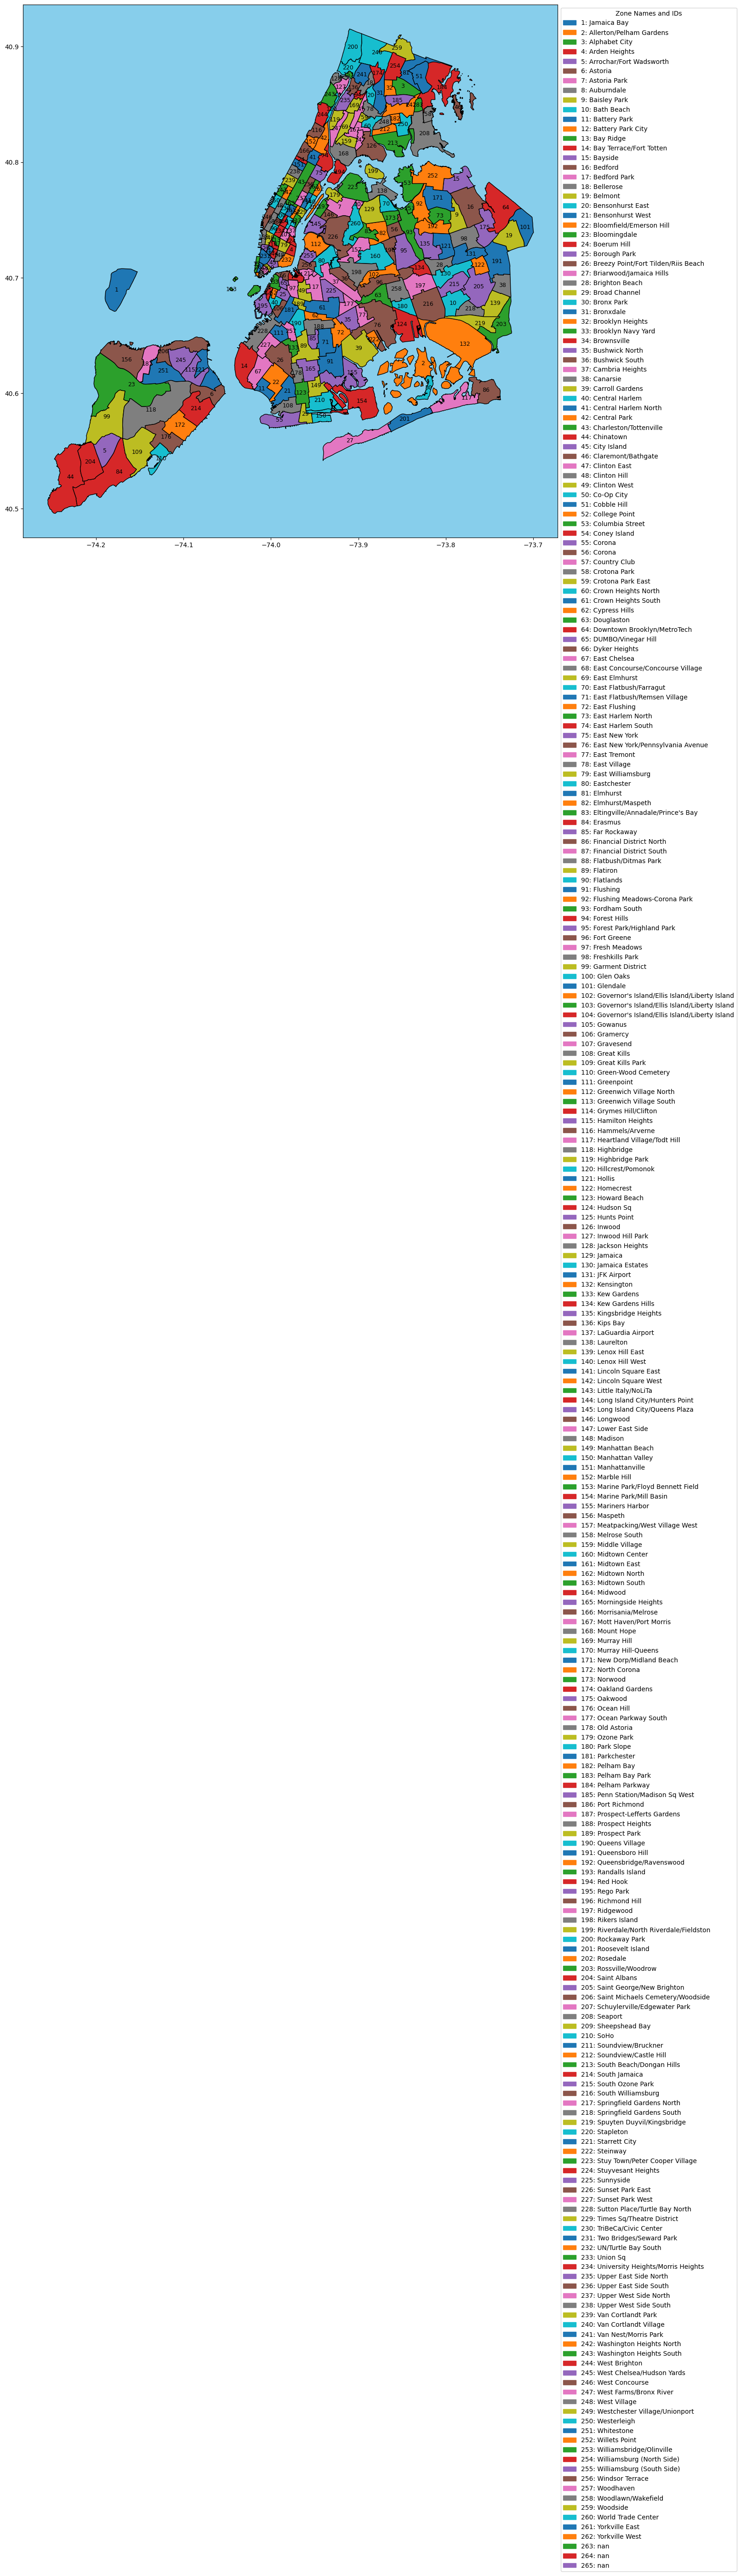

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the NYC Taxi Zones shapefile (or equivalent GeoDataFrame)
zones_gdf = gpd.read_file(TAXI_ZONES_DIR/'taxi_zones.shp')
zones_gdf = zones_gdf.to_crs(epsg=4326)  # Ensure CRS matches

# df_zones contains 'LocationID', 'zone', and the counts
top_zones = df_zones[['LocationID', 'zone']].drop_duplicates().set_index('LocationID')

# Map LocationIDs to colors (one unique color per LocationID)
# If you have many zones, you might want to use a colormap or predefined color palette
location_colors = {loc: f"C{i % 10}" for i, loc in enumerate(top_zones.index)}

# Define the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(15, 30))
ax.set_facecolor('skyblue')  # Set the plot background to sky blue within the axes

# Plot each zone with its corresponding color
for loc_id in top_zones.index:
    geom = zones_gdf[zones_gdf['LocationID'] == loc_id]
    if not geom.empty and geom.is_valid.all():  # Check if not empty and all geometries are valid
        geom.plot(ax=ax, color=location_colors[loc_id], edgecolor='black')

# Annotate the zones with the LocationID
for loc_id, row in top_zones.iterrows():
    geom = zones_gdf[zones_gdf['LocationID'] == loc_id]
    if not geom.empty and geom.is_valid.all():
        # Ensure we have a single representative point
        point = geom.representative_point().iloc[0]
        ax.text(point.x, point.y, str(loc_id), 
                horizontalalignment='center', verticalalignment='center', fontsize=9)

# Create a custom legend for the zones
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=f"{loc_id}: {top_zones.loc[loc_id, 'zone']}") 
                  for loc_id, color in location_colors.items()]
ax.legend(handles=legend_patches, title='Zone Names and IDs', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


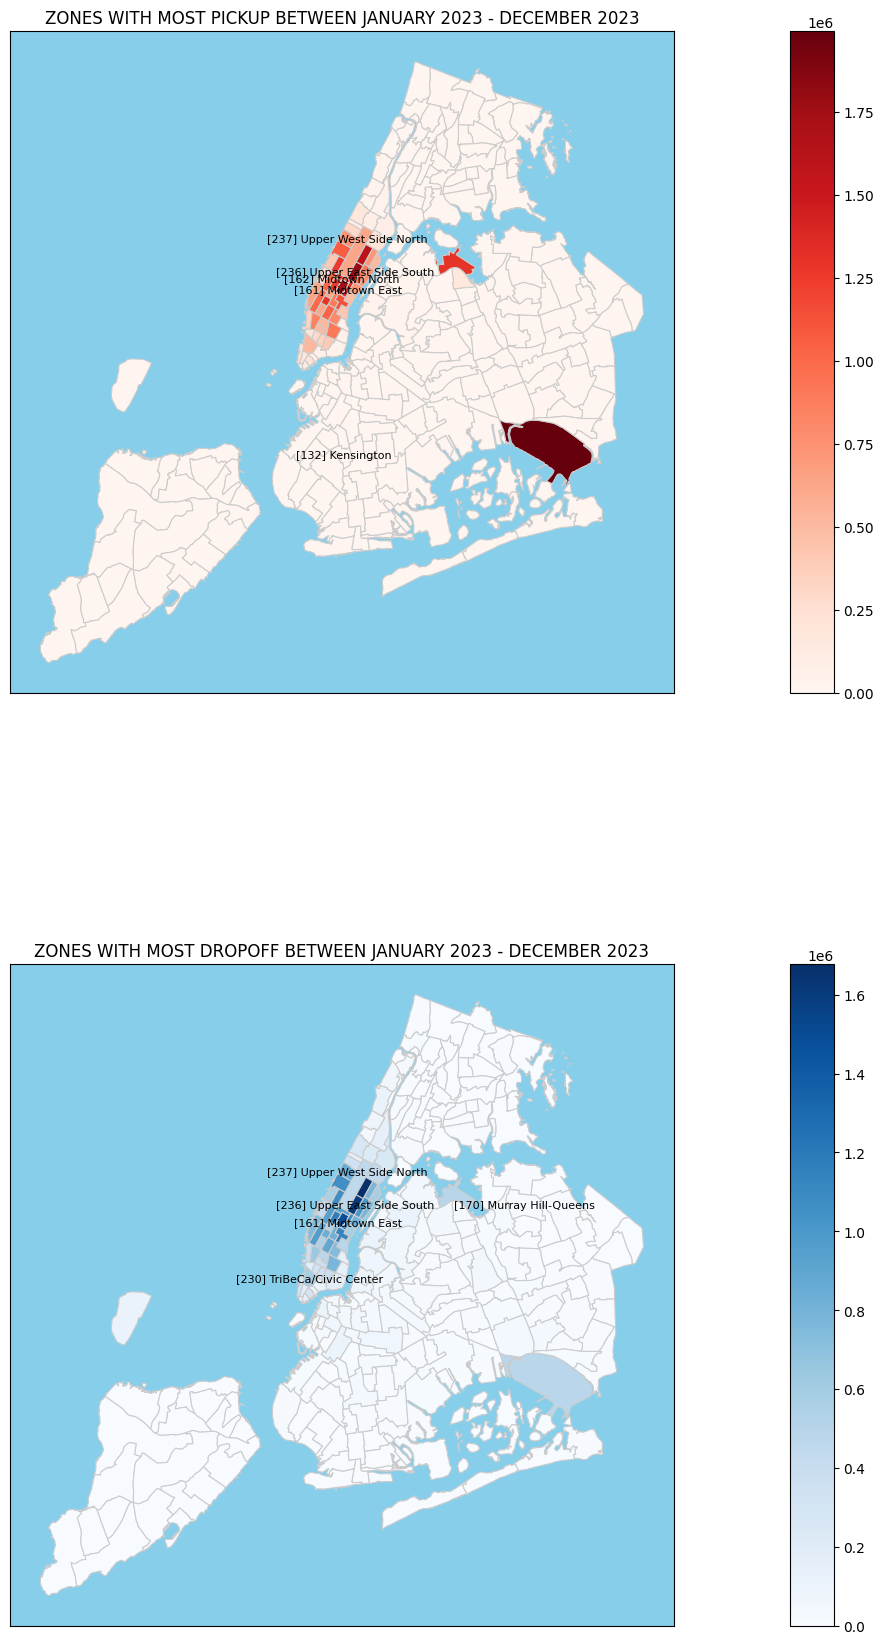

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the NYC Taxi Zones shapefile (or equivalent GeoDataFrame) 
zones_gdf = gpd.read_file(TAXI_ZONES_DIR/'taxi_zones.shp')
zones_gdf = zones_gdf.to_crs(epsg=4326)  # Ensure CRS matches

# Merge with the count data
zones_with_counts = zones_gdf.merge(df_zones, on='LocationID')

# Define the figure and axes for the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

# Plot choropleth maps
for idx, activity in enumerate(['pickup', 'dropoff']):
    ax = axs[idx]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    zones_with_counts.plot(column=activity, cmap='Reds' if activity == 'pickup' else 'Blues', 
                           linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)
    ax.set_title(f'ZONES WITH MOST {activity.upper()} BETWEEN JANUARY 2023 - DECEMBER 2023')
    ax.set_facecolor('skyblue')  # Set the plot background to sky blue
    ax.set_axis_on()  # Show the axis

    # Annotate with LocationID and zone names
    top_zones = PUtop5 if activity == 'pickup' else DOtop5
    for _, row in top_zones.iterrows():
        ax.annotate(text=f"[{row['LocationID']}] {row['zone']}", 
                    xy=(row['Longitude'], row['Latitude']),
                    horizontalalignment='center', verticalalignment='center',
                    color='black', fontsize=8)

# Turn on axis visibility for latitude and longitude
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)


plt.tight_layout()
plt.show()


In [17]:
# Group data by borough and aggregate counts
borough_aggregates = df_zones.groupby("borough", as_index=False).agg(
    PickupCount_sum=('pickup', 'sum'),
    DropoffCount_sum=('dropoff', 'sum'),
    TOTALcount_sum=('TOTALcount', 'sum')
)

# Sort the aggregated results by total counts in descending order
sorted_boroughs = borough_aggregates.sort_values(by='TOTALcount_sum', ascending=False)

# Assign the result back to df_borough if needed
df_borough_ = sorted_boroughs


In [18]:
df_location_info_aggregated = df_location_info.groupby('borough')[['Latitude', 'Longitude']].mean()
df_borough = df_borough_.merge(df_location_info_aggregated, on='borough')

In [19]:
df_borough

,borough,PickupCount_sum,DropoffCount_sum,TOTALcount_sum,Latitude,Longitude
0,Manhattan,16824638.0,17557812.0,34382450.0,40.761167,-73.978089
1,Brooklyn,7799499.0,6896610.0,14696109.0,40.655283,-73.959097
2,Bronx,5968256.0,6346331.0,12314587.0,40.849270,-73.875567
3,Queens,4065288.0,4150353.0,8215641.0,40.716871,-73.831578
4,Staten Island,2538653.0,2024722.0,4563375.0,40.585879,-74.138601


In [20]:
# Creating dictionaries mapping boroughs to their respective pickup and dropoff counts
pickup_count = df_borough.set_index('borough')['PickupCount_sum'].to_dict()
dropoff_count = df_borough.set_index('borough')['DropoffCount_sum'].to_dict()


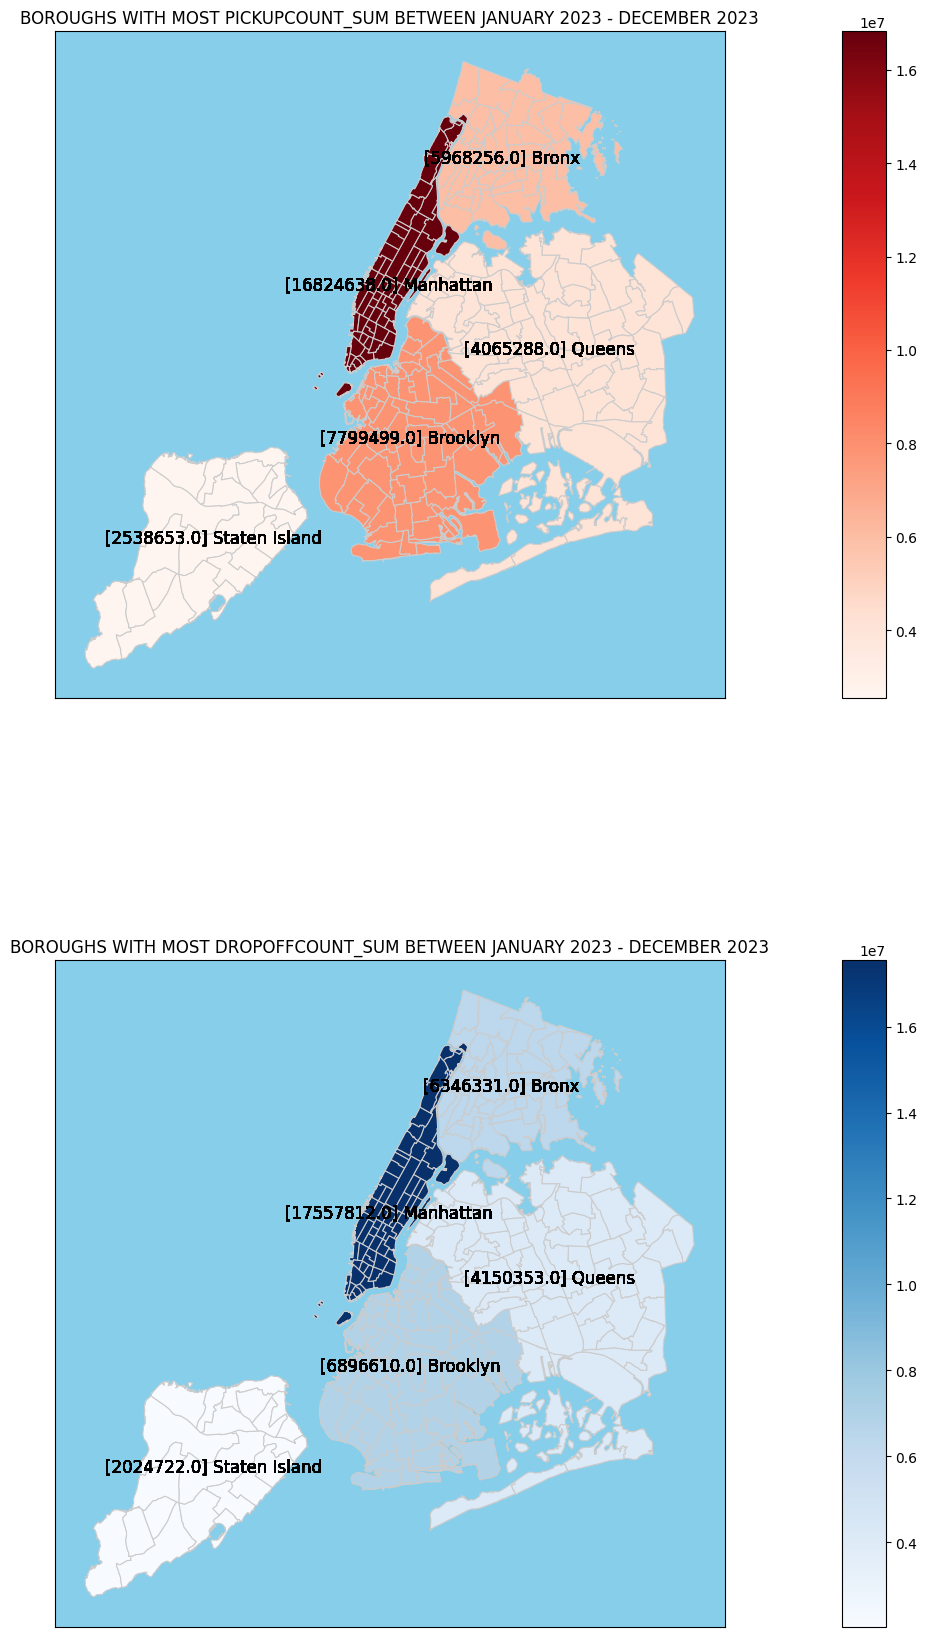

In [21]:
# Load the NYC Taxi Zones shapefile (or equivalent GeoDataFrame) 
boroughs_gdf = gpd.read_file(TAXI_ZONES_DIR/'taxi_zones.shp').to_crs(epsg=4326)  # Ensure CRS matches

# Merge with the count data
boroughs_with_counts = boroughs_gdf.merge(df_borough, on='borough')

# Define the figure and axes for the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

# Plot choropleth maps
for idx, activity in enumerate(['PickupCount_sum', 'DropoffCount_sum']):
    ax = axs[idx]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Check if activity is 'PickupCount_sum' or 'DropoffCount_sum' and adjust cmap and annotation accordingly
    cmap_color = 'Reds' if activity == 'PickupCount_sum' else 'Blues'
    boroughs_with_counts.plot(column=activity, cmap=cmap_color, 
                              linewidth=0.8, ax=ax, edgecolor='0.8', 
                              legend=True, cax=cax)
    ax.set_title(f'BOROUGHS WITH MOST {activity.upper()} BETWEEN JANUARY 2023 - DECEMBER 2023')
    ax.set_facecolor('skyblue')
    ax.set_axis_on()

    for _, row in boroughs_with_counts.iterrows():
        ax.annotate(text=f"[{row[activity]}] {row['borough']}", 
                    xy=(row['Longitude'], row['Latitude']),
                    horizontalalignment='center', verticalalignment='center',
                    color='black', fontsize=12)

# Turn on axis visibility for latitude and longitude
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)


plt.tight_layout()
plt.show()